# Imports

In [1]:
!pip install -q PyWavelets fastai

In [2]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
        confusion_matrix, ConfusionMatrixDisplay,
        f1_score, multilabel_confusion_matrix, accuracy_score, classification_report)

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

# import pywt
from fastai.vision.all import *
from fastai.callback.all import *

In [3]:
import torch.backends.cudnn as cudnn


def reproduce():
    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    cudnn.deterministic = True
    cudnn.benchmark = False
reproduce()

In [4]:
print(torch.__version__)

2.0.0


# Preparing Data

In [5]:
!ls ../input/incartdb-dataset
# !ls ../input/ptb-xl-lead-comparison

baseline_removed_100hz_incartdb.npz
baseline_removed_100hz_incartdb_labels.parquet


In [6]:
dataset_loc = "../input/incartdb-dataset"

In [7]:
signals = np.load(os.path.join(dataset_loc, "baseline_removed_100hz_incartdb.npz"))['arr_0']
signals.shape

(75, 12, 180000)

In [8]:
df = pd.read_parquet(os.path.join(dataset_loc, "baseline_removed_100hz_incartdb_labels.parquet"))
df

,labels
0,"Coronary artery disease, arterial hypertension"
1,"Coronary artery disease, arterial hypertension"
2,Acute MI
3,Acute MI
4,Acute MI
...,...
70,Normal
71,"Coronary artery disease, arterial hypertension, left ventricular hypertrophy"
72,"Coronary artery disease, arterial hypertension, left ventricular hypertrophy"
73,Earlier MI


In [9]:
df['labels'].unique()

array(['Coronary artery disease, arterial hypertension', 'Acute MI',
       'Transient ischemic attack', 'Normal',
       'Coronary artery disease, arterial hypertension, left ventricular hypertrophy',
       'Earlier MI', 'Sinus node dysfunction'], dtype=object)

In [10]:
label_encoder = LabelEncoder()
df['labels_encoded'] = label_encoder.fit_transform(df['labels'])

In [11]:
# dir(label_encoder.get_params)
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
label_mapping

{'Acute MI': 0,
 'Coronary artery disease, arterial hypertension': 1,
 'Coronary artery disease, arterial hypertension, left ventricular hypertrophy': 2,
 'Earlier MI': 3,
 'Normal': 4,
 'Sinus node dysfunction': 5,
 'Transient ischemic attack': 6}

In [12]:
len(label_mapping)

7

In [13]:
df_expanded = pd.DataFrame(np.repeat(df.values, 180, axis=0), columns=df.columns)

# Resetting the index
df_expanded.reset_index(drop=True, inplace=True)

In [14]:
df_expanded

,labels,labels_encoded
0,"Coronary artery disease, arterial hypertension",1
1,"Coronary artery disease, arterial hypertension",1
2,"Coronary artery disease, arterial hypertension",1
3,"Coronary artery disease, arterial hypertension",1
4,"Coronary artery disease, arterial hypertension",1
...,...,...
13495,Earlier MI,3
13496,Earlier MI,3
13497,Earlier MI,3
13498,Earlier MI,3


In [15]:
df_expanded['labels_encoded'].value_counts()

4    6120
2    1980
3    1620
6    1260
1    1080
0    1080
5     360
Name: labels_encoded, dtype: int64

In [16]:
train_set, test_set = train_test_split(df_expanded, test_size=0.20, random_state=42, stratify=df_expanded['labels_encoded'])

In [17]:
train_set, val_set = train_test_split(train_set, test_size=0.20, random_state=42, stratify=train_set['labels_encoded'])

In [18]:
print(train_set.shape)
print(test_set.shape)
print(val_set.shape)

(8640, 2)
(2700, 2)
(2160, 2)


In [19]:
# from the metadata of WFDB sample
leads = ['I','II','III','AVR','AVL','AVF','V1','V2','V3','V4','V5','V6']

leads_index = {l:i for i, l in enumerate(leads)}
leads_index

{'I': 0,
 'II': 1,
 'III': 2,
 'AVR': 3,
 'AVL': 4,
 'AVF': 5,
 'V1': 6,
 'V2': 7,
 'V3': 8,
 'V4': 9,
 'V5': 10,
 'V6': 11}

# PyTorch Dataset Class

In [20]:
def decompose(signal, level=3, **kwargs):
    lvl = kwargs.get("level", level)
    return pywt.wavedec(signal, 'db6', level=lvl)[0]

def minmax_norm(sig, **kwargs):
    s_min, s_max = sig.min(), sig.max()
    s_norm = (sig - s_min) / (s_max - s_min)
    return s_norm

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [22]:
# device = "cpu" # for debugging

# Fine-tuning for the disease detection

In [23]:
class DiseaseDetectionDataset(Dataset):
    def __init__(self, df, signals, lead, transform=None, **kwargs):
        self.df = df
        self.signals = signals
        self.lead = lead
        self.transform = transform
        self.kwargs = kwargs
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        instance = self.df.iloc[idx] # data instance
        index = instance.name
        label = instance['labels_encoded']
        
        p1 = index // 180 
        p2 = index % 180
        
        signal = self.signals[p1, :, p2*1000: (p2+1)*1000]
        
        if type(self.lead) == list:
            channels = []
            for i in self.lead:
                channels.append(leads_index[i])
            signal = signal[channels]
        else:
            channel = leads_index.get(self.lead, None)
            if channel is not None:
                signal = signal[channel][None, :]
            
        if self.transform:
            if type(self.transform) == list:
                for t in transform:
                    signal = t(signal, **self.kwargs)
            else:
                signal = self.transform(signal, **self.kwargs)
        
        return torch.tensor(signal, dtype=torch.float32).to(device), torch.tensor(label).to(device)

In [24]:
# BATCH_SIZE = 32
# train_dataset_dd = DiseaseDetectionDataset(train_set, signals, "all", minmax_norm)

# sig, label = train_dataset_dd[0]

# sig.shape, label.shape

In [25]:
# BATCH_SIZE = 32
# train_dataset_dd = DiseaseDetectionDataset(train_set, signals, "all", minmax_norm)
# val_dataset_dd = DiseaseDetectionDataset(val_set, signals, "all", minmax_norm)
# test_dataset_dd = DiseaseDetectionDataset(test_set, signals, "all", minmax_norm)

# train_dataloader_dd = DataLoader(train_dataset_dd, batch_size=BATCH_SIZE, shuffle=True)
# val_dataloader_dd = DataLoader(val_dataset_dd, batch_size=BATCH_SIZE, shuffle=True)
# test_dataloader_dd = DataLoader(test_dataset_dd, batch_size=BATCH_SIZE, shuffle=True)

In [26]:
# for x, y in test_dataloader_dd:
#     test_shape = x.shape, y.shape
#     print(test_shape)
#     break

In [27]:
class ECGTransformerDD(nn.Module):
    def __init__(self, n_channels, d_model=500, n_filters = 32, nhead=5, n_enc_layers=8):
        # AssertionError: embed_dim must be divisible by num_heads
        super().__init__()
        self.conv_1 = nn.Conv1d(n_channels, n_filters, 8, stride=1, padding='same')
        self.norm_1 = nn.BatchNorm1d(n_filters)
        self.conv_2 = nn.Conv1d(   n_filters, n_filters, 5, stride=1, padding='same')
        self.norm_2 = nn.BatchNorm1d(n_filters)
        self.conv_3 = nn.Conv1d(   n_filters, n_filters, 3, stride=1, padding='same')
        self.norm_3 = nn.BatchNorm1d(n_filters)
        self.conv_4 = nn.Conv1d(n_channels, n_filters, 1, stride=1, padding='same') # Expanding for addition
        self.norm_4 = nn.BatchNorm1d(n_filters)

        self.conv_5 = nn.Conv1d(  n_filters, n_filters*2, 8, stride=1, padding='same')
        self.norm_5 = nn.BatchNorm1d(n_filters*2)
        self.conv_6 = nn.Conv1d(n_filters*2, n_filters*2, 5, stride=1, padding='same')
        self.norm_6 = nn.BatchNorm1d(n_filters*2)
        self.conv_7 = nn.Conv1d(n_filters*2, n_filters*2, 3, stride=1, padding='same')
        self.norm_7 = nn.BatchNorm1d(n_filters*2)
        self.conv_8 = nn.Conv1d(  n_filters, n_filters*2, 1, stride=1, padding='same')
        self.norm_8 = nn.BatchNorm1d(n_filters*2)

        self.conv_9  = nn.Conv1d(n_filters*2, n_filters*2, 8, stride=1, padding='same')
        self.norm_9 = nn.BatchNorm1d(n_filters*2)
        self.conv_10 = nn.Conv1d(n_filters*2, n_filters*2, 5, stride=1, padding='same')
        self.norm_10 = nn.BatchNorm1d(n_filters*2)
        self.conv_11 = nn.Conv1d(n_filters*2, n_filters*2, 3, stride=1, padding='same')
        self.norm_11 = nn.BatchNorm1d(n_filters*2)
        self.conv_12 = nn.Conv1d(n_filters*2, n_filters*2, 1, stride=1, padding='same')
        self.norm_12 = nn.BatchNorm1d(n_filters*2)
        self.pool = nn.MaxPool1d(kernel_size=2) # default stride is equal to the kernel_size
        self.flatten = nn.Flatten()
        
        self.encoder = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        
        self.linear_1 = nn.Linear(d_model*n_filters*2, 7)

    def forward(self, x):
        x = x.float()
        
        # Block 1
        a = self.conv_1(x)
        a = self.norm_1(a)
        a = F.relu(a)
        
        b = self.conv_2(a)
        b = self.norm_2(b)
        b = F.relu(b)
        
        c = self.conv_3(b)
        c = self.norm_3(c)
        
        shortcut = self.conv_4(x)
        shortcut = self.norm_4(shortcut)
        
        output_1 = torch.add(c, shortcut)
        output_1 = F.relu(output_1)
        
        #Block 2
        a = self.conv_5(output_1)
        a = self.norm_5(a)
        a = F.relu(a)
        
        b = self.conv_6(a)
        b = self.norm_6(b)
        b = F.relu(b)
        
        c = self.conv_7(b)
        c = self.norm_7(c)
        shortcut = self.conv_8(output_1)
        shortcut = self.norm_8(shortcut)
        
        output_2 = torch.add(c, shortcut)
        output_2 = F.relu(output_2)
        
        #Block 3
        a = self.conv_9(output_2)
        a = self.norm_9(a)
        a = F.relu(a)
        
        b = self.conv_10(a)
        b = self.norm_10(b)
        b = F.relu(b)
        
        c = self.conv_11(b)
        c = self.norm_11(c)
        
#         shortcut = self.conv_12(output_2)
        shortcut = self.norm_12(shortcut)
        
        output_3 = torch.add(c, shortcut)
        output_3 = F.relu(output_3)
        x = self.pool(output_3)

        x = self.encoder(x)

        x = self.flatten(x)
        logits = self.linear_1(x)
        return logits

In [28]:
# dd_model = ECGTransformerDD(n_channels=test_shape[0][1]).to(device) 
# # base_dd_model = ECGTransformerDD(n_channels=test_shape[1]).to(device) 
# dd_model(torch.randn(test_shape[0]).to(device)).shape

In [29]:
# test = dd_model(torch.randn(test_shape[0]).to(device))
# y

# f1_score(y.cpu(), test.argmax(axis=-1).cpu(), average="weighted")

# Model training

In [30]:
total_class_sum = df_expanded['labels_encoded'].value_counts()
total_class_sum

4    6120
2    1980
3    1620
6    1260
1    1080
0    1080
5     360
Name: labels_encoded, dtype: int64

In [31]:
total_samples = total_class_sum.sum()
num_classes = len(label_mapping)

In [32]:
class_weights = total_class_sum.apply(lambda x: total_samples/(x * num_classes))
class_weights

4    0.315126
2    0.974026
3    1.190476
6    1.530612
1    1.785714
0    1.785714
5    5.357143
Name: labels_encoded, dtype: float64

In [33]:
class_weights = torch.tensor(class_weights.values).float().to(device)

In [34]:
# dls = DataLoaders(train_dataloader_dd, val_dataloader_dd)
# loss_fn = nn.CrossEntropyLoss(weight=class_weights)
# learner = Learner(
#     dls,
#     dd_model,
#     loss_func=loss_fn,    
#     metrics=[F1Score(average='weighted')] # from fast ai
# )

In [35]:
# learner.fit(
#     50, 
#     1e-3,
# #     cbs=[
# #         EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001,patience=5, reset_on_fit=True)
# #     ]
# )

In [36]:
# learner.recorder.plot_loss()

In [37]:
# y_pred = []
# y_true = []
# with torch.no_grad():
#     for inputs, labels in tqdm(test_dataloader_dd):
#         output = dd_model(inputs.to(device).float())
# #         output = (output > 0.5).int()
#         y_pred.extend(output)
# #         labels = labels.data.cpu().int().numpy()
#         y_true.extend(labels)
# y_true = torch.stack(y_true).cpu()
# y_pred = torch.stack(y_pred).cpu()

In [38]:
# metric = F1Score(average='weighted')

In [39]:
# metric(y_true, y_pred.argmax(axis=-1))

In [40]:
# label_mapping.keys()

In [41]:
# res = classification_report(y_true, y_pred.argmax(axis=-1), target_names=label_mapping.keys())
# print(res)

weight_for_class_i = total_samples / (num_samples_in_class_i * num_classes)

# Experiment Design

In [42]:
def get_dd_loaders(batch_size, leads):
    # BATCH_SIZE = 32
    train_dataset_dd = DiseaseDetectionDataset(train_set, signals, leads, minmax_norm)
    val_dataset_dd = DiseaseDetectionDataset(val_set, signals, leads, minmax_norm)
    test_dataset_dd = DiseaseDetectionDataset(test_set, signals, leads, minmax_norm)

    train_dataloader_dd = DataLoader(train_dataset_dd, batch_size=batch_size, shuffle=True)
    val_dataloader_dd = DataLoader(val_dataset_dd, batch_size=batch_size, shuffle=True)
    test_dataloader_dd = DataLoader(test_dataset_dd, batch_size=batch_size, shuffle=True)

    return train_dataloader_dd, val_dataloader_dd, test_dataloader_dd

In [43]:
def get_models(channels):
    dd_model = ECGTransformerDD(n_channels=channels).to(device) 
    
    return dd_model

In [44]:
def get_dd_learner(train_dataloader, val_dataloader, model):
    # dd_model = ECGResNetVanilla(len(classes), test_shape[1]).to(device) 
    dls = DataLoaders(train_dataloader, val_dataloader)
    loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    learner = Learner(
        dls,
        model,
        loss_func=loss_fn,    
        metrics=[F1Score(average='weighted')] # from fast ai
    )
    return learner

In [45]:
def fit_dd(learner, epochs, fname, lr=1e-3):
    learner.fit(
        epochs, 
        lr,
        cbs=[
    #         EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001,patience=5, reset_on_fit=True),
            SaveModelCallback(monitor='f1_score', min_delta=0.001, fname=fname)
        ]
    )

In [46]:
def save_learning_curve(learner, fname):
    learner.recorder.plot_loss()
    plt.gca().set_title(f"Training and Validation loss, {fname}")
    plt.savefig(f"plots/{fname}_learning_curve.png")

In [47]:
def test_model(learner, test_loader, fname):
    learner.model.load_state_dict(
        torch.load(f"models/{fname}.pth", map_location=torch.device(device)))
    learner.model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            output = learner.model(inputs.to(device).float())
    #         output = (output > 0.5).int()
            y_pred.extend(output)
    #         labels = labels.data.cpu().int().numpy()
            y_true.extend(labels)
    y_true = torch.stack(y_true).cpu()
    y_pred = torch.stack(y_pred).cpu().argmax(axis=-1)
    return y_true, y_pred

In [48]:
def evaluate(y_true, y_pred, fname):
    print(classification_report(y_true, y_pred, target_names=label_mapping.keys(), digits=4))
    matrices = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.savefig(f"plots/{fname}_confusion_matrix.png")

## Testing the pipeline

In [49]:
BATCH_SIZE = 32
EPOCHS = 50
leads = "I"
#['I','II','III','AVR','AVL','AVF','V1','V2','V3','V4','V5','V6']

In [50]:
os.makedirs("plots", exist_ok=True)

In [51]:
type(leads)

str

In [52]:
def run_pipeline(leads):
    if type(leads) is list:
        fname = "-".join(leads)
        channels = len(leads)
    else:
        fname = leads
        channels = 1
        
    # getting loaders
    train_loader_dd, val_loader_dd, test_loader_dd = get_dd_loaders(BATCH_SIZE, leads)
    
    reproduce()
    dd_model = get_models(channels)
    
    dd_learner = get_dd_learner(train_loader_dd, val_loader_dd, dd_model)
    
    fit_dd(dd_learner, EPOCHS, f"{fname}_dd", lr=1e-3)
    save_learning_curve(dd_learner, f"{fname}_dd")
    plt.show()
    
    plt.show()
    print("Testing model...")
    y_true, y_pred = test_model(dd_learner, test_loader_dd, f"{fname}_dd")
    evaluate(y_true, y_pred, f"{fname}_dd")
    plt.show()

epoch,train_loss,valid_loss,f1_score,time
0,3.040660,2.305797,0.507229,00:16
1,1.124643,1.199590,0.605993,00:11
2,0.686569,1.350579,0.708257,00:11
3,0.598042,1.090730,0.737071,00:11
4,0.422894,1.012506,0.783528,00:11
5,0.324209,0.977779,0.766139,00:11
6,0.264101,0.921598,0.828764,00:11
7,0.255980,1.208147,0.818749,00:11
8,0.245814,1.161479,0.804259,00:11
9,0.198331,1.269488,0.844411,00:11


Better model found at epoch 0 with f1_score value: 0.5072287144285628.
Better model found at epoch 1 with f1_score value: 0.6059928093834206.
Better model found at epoch 2 with f1_score value: 0.7082570710948315.
Better model found at epoch 3 with f1_score value: 0.737070807881711.
Better model found at epoch 4 with f1_score value: 0.7835279636844453.
Better model found at epoch 6 with f1_score value: 0.8287644777019211.
Better model found at epoch 9 with f1_score value: 0.8444106915958051.
Better model found at epoch 13 with f1_score value: 0.8532488799496312.
Better model found at epoch 17 with f1_score value: 0.8740181395378225.
Better model found at epoch 21 with f1_score value: 0.875337532804302.
Better model found at epoch 22 with f1_score value: 0.8835633247399759.
Better model found at epoch 23 with f1_score value: 0.8908931618408877.
Better model found at epoch 34 with f1_score value: 0.9073324843127769.


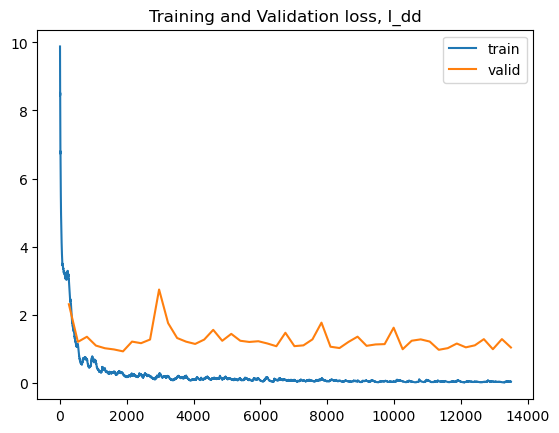

Testing model...


  0%|          | 0/85 [00:00<?, ?it/s]

                                                                              precision    recall  f1-score   support

                                                                    Acute MI     0.9402    0.8009    0.8650       216
                              Coronary artery disease, arterial hypertension     0.9634    0.8519    0.9042       216
Coronary artery disease, arterial hypertension, left ventricular hypertrophy     0.9247    0.8990    0.9117       396
                                                                  Earlier MI     0.9379    0.8858    0.9111       324
                                                                      Normal     0.8737    0.9551    0.9126      1224
                                                      Sinus node dysfunction     0.9298    0.7361    0.8217        72
                                                   Transient ischemic attack     0.9414    0.8929    0.9165       252

                                                      

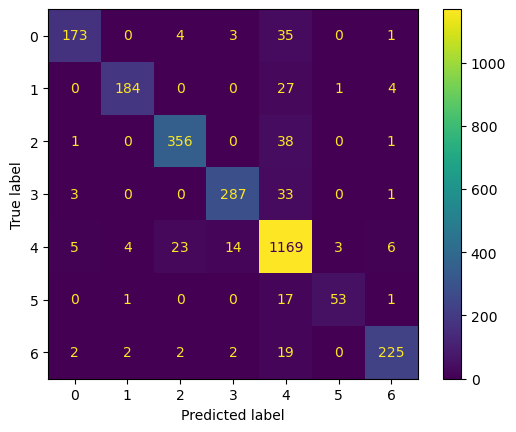

In [53]:
run_pipeline(['I'])

In [54]:
# run_pipeline(['I','II','III','AVR','AVL','AVF','V1','V2','V3','V4','V5','V6'])

epoch,train_loss,valid_loss,f1_score,time
0,2.373623,2.005811,0.533412,00:11
1,0.835766,0.665966,0.790104,00:11
2,0.445886,0.321048,0.880942,00:11
3,0.355365,0.350883,0.876549,00:11
4,0.330855,0.487404,0.840092,00:11
5,0.316312,0.547797,0.886859,00:11
6,0.197170,0.408232,0.926195,00:11
7,0.148557,0.296633,0.907336,00:11
8,0.112682,0.515636,0.892901,00:11
9,0.084467,0.358327,0.940873,00:11


Better model found at epoch 0 with f1_score value: 0.5334121666276732.
Better model found at epoch 1 with f1_score value: 0.790104313596672.
Better model found at epoch 2 with f1_score value: 0.8809419403214265.
Better model found at epoch 5 with f1_score value: 0.8868593037035077.
Better model found at epoch 6 with f1_score value: 0.9261947724770102.
Better model found at epoch 9 with f1_score value: 0.9408728712591133.
Better model found at epoch 12 with f1_score value: 0.947514239716869.
Better model found at epoch 17 with f1_score value: 0.9554091425691726.
Better model found at epoch 20 with f1_score value: 0.9614859526024645.
Better model found at epoch 24 with f1_score value: 0.9646876976359823.
Better model found at epoch 25 with f1_score value: 0.9662084635047631.
Better model found at epoch 37 with f1_score value: 0.9731294790463325.
Better model found at epoch 49 with f1_score value: 0.9790683970816236.


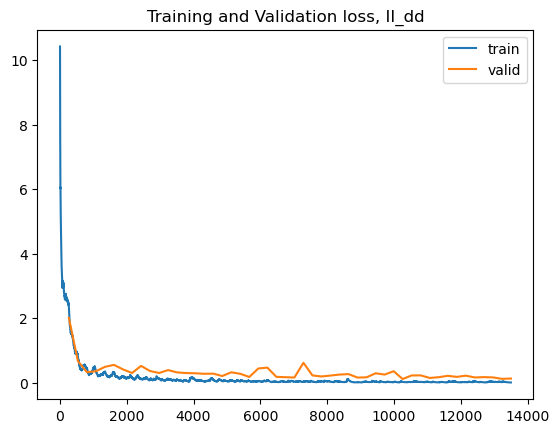

Testing model...


  0%|          | 0/85 [00:00<?, ?it/s]

                                                                              precision    recall  f1-score   support

                                                                    Acute MI     0.9772    0.9907    0.9839       216
                              Coronary artery disease, arterial hypertension     0.9630    0.9630    0.9630       216
Coronary artery disease, arterial hypertension, left ventricular hypertrophy     0.9658    0.9975    0.9814       396
                                                                  Earlier MI     0.9878    0.9969    0.9923       324
                                                                      Normal     0.9893    0.9779    0.9836      1224
                                                      Sinus node dysfunction     0.9855    0.9444    0.9645        72
                                                   Transient ischemic attack     0.9840    0.9762    0.9801       252

                                                      

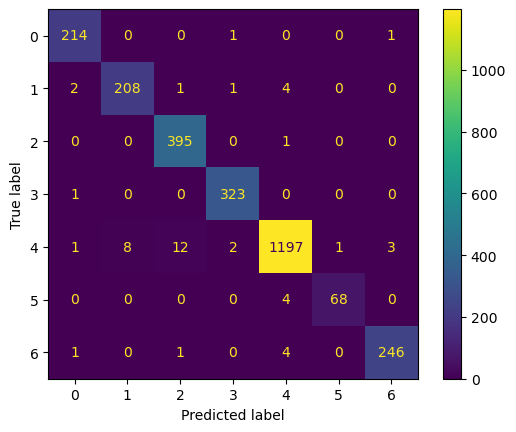

In [55]:
run_pipeline(['II'])

epoch,train_loss,valid_loss,f1_score,time
0,2.587334,1.662077,0.486886,00:11
1,0.796008,0.653646,0.744183,00:11
2,0.544578,0.734594,0.809588,00:11
3,0.392615,0.592308,0.852066,00:11
4,0.288751,0.287612,0.928413,00:11
5,0.257579,0.669405,0.849359,00:11
6,0.294870,0.651836,0.831784,00:11
7,0.107552,0.314609,0.912539,00:11
8,0.139136,0.420586,0.907399,00:11
9,0.128752,0.360313,0.925526,00:11


Better model found at epoch 0 with f1_score value: 0.48688605884820335.
Better model found at epoch 1 with f1_score value: 0.7441827390332288.
Better model found at epoch 2 with f1_score value: 0.8095880157981321.
Better model found at epoch 3 with f1_score value: 0.8520655710738273.
Better model found at epoch 4 with f1_score value: 0.9284126422526912.
Better model found at epoch 12 with f1_score value: 0.9443241813471264.
Better model found at epoch 15 with f1_score value: 0.9456128576183905.
Better model found at epoch 20 with f1_score value: 0.9497754191163027.
Better model found at epoch 22 with f1_score value: 0.9535960059408665.
Better model found at epoch 25 with f1_score value: 0.9617865045443453.
Better model found at epoch 34 with f1_score value: 0.9725862032150676.


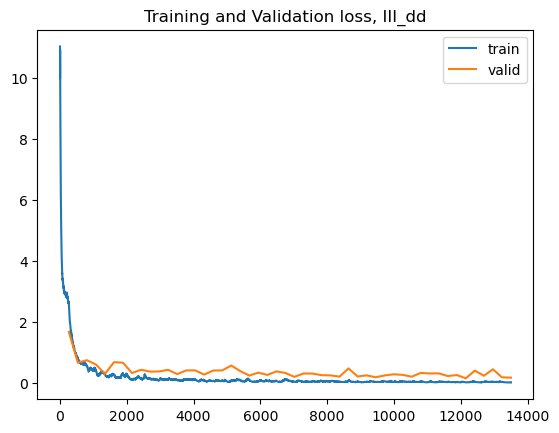

Testing model...


  0%|          | 0/85 [00:00<?, ?it/s]

                                                                              precision    recall  f1-score   support

                                                                    Acute MI     0.9526    0.9306    0.9415       216
                              Coronary artery disease, arterial hypertension     0.8879    0.9167    0.9021       216
Coronary artery disease, arterial hypertension, left ventricular hypertrophy     0.9847    0.9773    0.9810       396
                                                                  Earlier MI     0.9688    0.9599    0.9643       324
                                                                      Normal     0.9587    0.9853    0.9718      1224
                                                      Sinus node dysfunction     1.0000    0.8333    0.9091        72
                                                   Transient ischemic attack     0.9573    0.8889    0.9218       252

                                                      

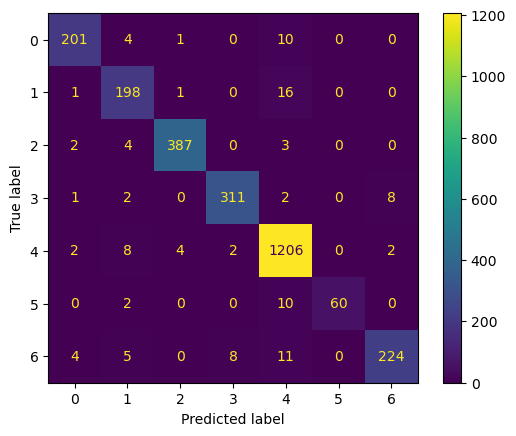

In [56]:
run_pipeline(['III'])

epoch,train_loss,valid_loss,f1_score,time
0,1.539501,1.129482,0.565402,00:11
1,0.645412,0.525806,0.794845,00:11
2,0.576209,0.700496,0.802498,00:11
3,0.417535,0.632182,0.801565,00:11
4,0.282149,0.382108,0.867092,00:11
5,0.262537,0.728648,0.848341,00:11
6,0.250698,0.692471,0.831509,00:11
7,0.188815,1.770209,0.715794,00:11
8,0.101991,0.591870,0.871693,00:11
9,0.101984,0.420910,0.912157,00:11


Better model found at epoch 0 with f1_score value: 0.5654023196534935.
Better model found at epoch 1 with f1_score value: 0.7948453224471167.
Better model found at epoch 2 with f1_score value: 0.8024984243544766.
Better model found at epoch 4 with f1_score value: 0.8670920423370563.
Better model found at epoch 8 with f1_score value: 0.8716925959673146.
Better model found at epoch 9 with f1_score value: 0.9121569852977507.
Better model found at epoch 14 with f1_score value: 0.9228527773773865.
Better model found at epoch 20 with f1_score value: 0.9496754539667223.
Better model found at epoch 24 with f1_score value: 0.9623724698755135.


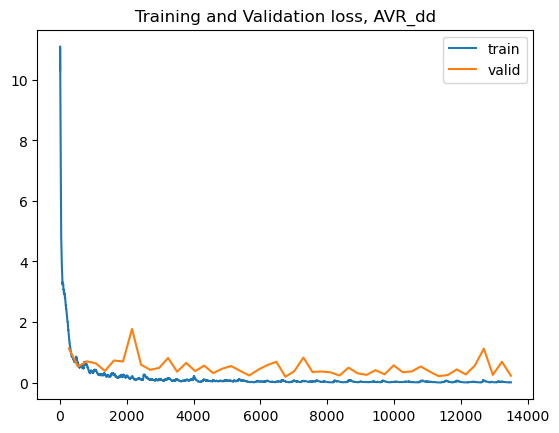

Testing model...


  0%|          | 0/85 [00:00<?, ?it/s]

                                                                              precision    recall  f1-score   support

                                                                    Acute MI     0.9517    0.9120    0.9314       216
                              Coronary artery disease, arterial hypertension     0.9754    0.9167    0.9451       216
Coronary artery disease, arterial hypertension, left ventricular hypertrophy     0.9509    0.9773    0.9639       396
                                                                  Earlier MI     0.9814    0.9753    0.9783       324
                                                                      Normal     0.9634    0.9681    0.9658      1224
                                                      Sinus node dysfunction     0.9028    0.9028    0.9028        72
                                                   Transient ischemic attack     0.9305    0.9563    0.9432       252

                                                      

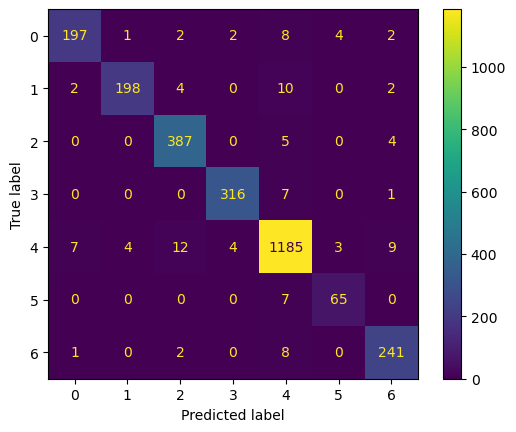

In [57]:
run_pipeline(['AVR'])

epoch,train_loss,valid_loss,f1_score,time
0,1.998266,1.534357,0.388629,00:11
1,1.033431,0.846355,0.625073,00:10
2,0.676796,0.679340,0.734146,00:11
3,0.449018,0.569131,0.800435,00:11
4,0.291259,0.846808,0.814382,00:11
5,0.307062,0.796074,0.781249,00:11
6,0.257680,0.699058,0.787967,00:10
7,0.181104,0.616372,0.850477,00:11
8,0.218710,0.901589,0.795427,00:11
9,0.143912,0.630247,0.862496,00:11


Better model found at epoch 0 with f1_score value: 0.3886289373973586.
Better model found at epoch 1 with f1_score value: 0.625073403345951.
Better model found at epoch 2 with f1_score value: 0.734145862595588.
Better model found at epoch 3 with f1_score value: 0.800434735425931.
Better model found at epoch 4 with f1_score value: 0.8143822109386178.
Better model found at epoch 7 with f1_score value: 0.8504772011249037.
Better model found at epoch 9 with f1_score value: 0.8624964472728306.
Better model found at epoch 14 with f1_score value: 0.8686061185925136.
Better model found at epoch 15 with f1_score value: 0.8780489347641357.
Better model found at epoch 20 with f1_score value: 0.8928928434745318.
Better model found at epoch 26 with f1_score value: 0.901563891281925.
Better model found at epoch 34 with f1_score value: 0.9108488217647215.
Better model found at epoch 49 with f1_score value: 0.9241894251191024.


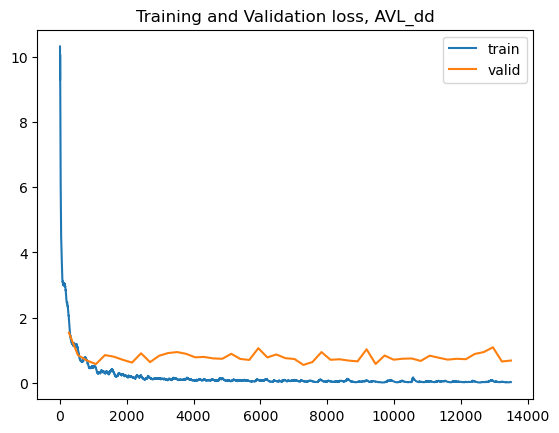

Testing model...


  0%|          | 0/85 [00:00<?, ?it/s]

                                                                              precision    recall  f1-score   support

                                                                    Acute MI     0.9563    0.9120    0.9336       216
                              Coronary artery disease, arterial hypertension     0.7863    0.8519    0.8178       216
Coronary artery disease, arterial hypertension, left ventricular hypertrophy     0.8947    0.9444    0.9189       396
                                                                  Earlier MI     0.9709    0.9259    0.9479       324
                                                                      Normal     0.9292    0.9436    0.9364      1224
                                                      Sinus node dysfunction     0.9833    0.8194    0.8939        72
                                                   Transient ischemic attack     0.9348    0.8532    0.8921       252

                                                      

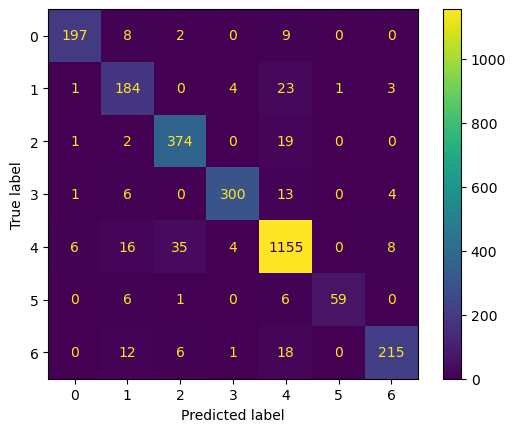

In [58]:
run_pipeline(['AVL'])

epoch,train_loss,valid_loss,f1_score,time
0,2.324341,1.789579,0.572078,00:11
1,0.703269,0.543003,0.830952,00:11
2,0.474117,0.751556,0.726559,00:11
3,0.366434,0.389617,0.847321,00:11
4,0.220484,0.239316,0.913469,00:11
5,0.264960,0.433146,0.899373,00:11
6,0.224995,0.275354,0.926934,00:10
7,0.146789,0.295857,0.903441,00:11
8,0.122574,0.475832,0.902662,00:11
9,0.096221,0.212062,0.945907,00:11


Better model found at epoch 0 with f1_score value: 0.5720784766776996.
Better model found at epoch 1 with f1_score value: 0.8309521262919537.
Better model found at epoch 3 with f1_score value: 0.8473208038199934.
Better model found at epoch 4 with f1_score value: 0.9134691357825092.
Better model found at epoch 6 with f1_score value: 0.9269338733471592.
Better model found at epoch 9 with f1_score value: 0.9459073533784581.
Better model found at epoch 13 with f1_score value: 0.9572678713972811.
Better model found at epoch 21 with f1_score value: 0.9715461298420262.
Better model found at epoch 39 with f1_score value: 0.9735676123217081.
Better model found at epoch 42 with f1_score value: 0.9787131805566535.


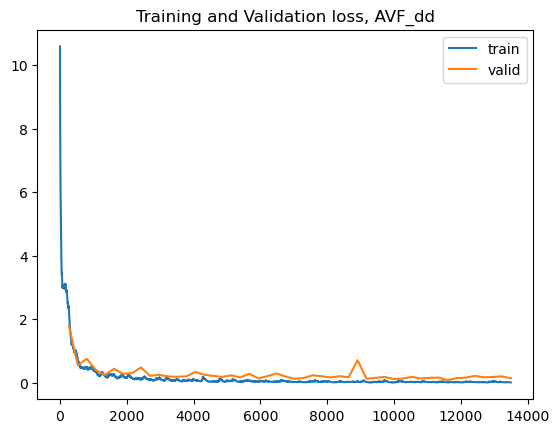

Testing model...


  0%|          | 0/85 [00:00<?, ?it/s]

                                                                              precision    recall  f1-score   support

                                                                    Acute MI     0.9855    0.9444    0.9645       216
                              Coronary artery disease, arterial hypertension     0.9706    0.9167    0.9429       216
Coronary artery disease, arterial hypertension, left ventricular hypertrophy     0.9872    0.9773    0.9822       396
                                                                  Earlier MI     0.9906    0.9722    0.9813       324
                                                                      Normal     0.9733    0.9837    0.9785      1224
                                                      Sinus node dysfunction     0.9211    0.9722    0.9459        72
                                                   Transient ischemic attack     0.9286    0.9802    0.9537       252

                                                      

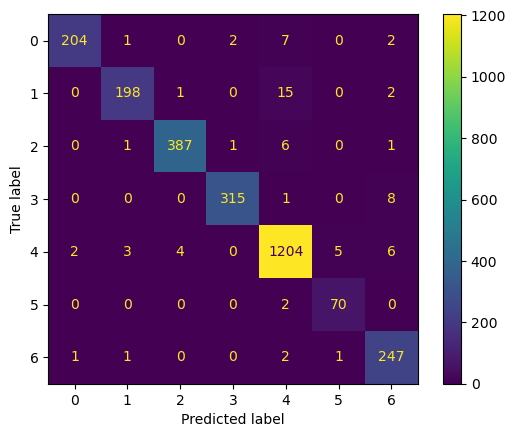

In [59]:
run_pipeline(['AVF'])

epoch,train_loss,valid_loss,f1_score,time
0,1.220620,0.917236,0.538453,00:11
1,0.687813,0.803333,0.704039,00:11
2,0.454230,0.582866,0.789994,00:11
3,0.395717,0.743446,0.741785,00:11
4,0.235436,0.529863,0.874969,00:10
5,0.203906,0.545799,0.854354,00:11
6,0.193383,0.414427,0.906670,00:10
7,0.196743,0.861854,0.824959,00:11
8,0.161653,0.674794,0.879373,00:11
9,0.192572,0.966302,0.856978,00:11


Better model found at epoch 0 with f1_score value: 0.5384525910208459.
Better model found at epoch 1 with f1_score value: 0.7040389107981062.
Better model found at epoch 2 with f1_score value: 0.7899940591631628.
Better model found at epoch 4 with f1_score value: 0.8749689976105554.
Better model found at epoch 6 with f1_score value: 0.9066702000691107.
Better model found at epoch 13 with f1_score value: 0.9343271277210298.
Better model found at epoch 16 with f1_score value: 0.9449643326970777.
Better model found at epoch 18 with f1_score value: 0.9512642467275076.
Better model found at epoch 20 with f1_score value: 0.9556979544183078.
Better model found at epoch 25 with f1_score value: 0.9568556108054812.
Better model found at epoch 27 with f1_score value: 0.9622367055832216.
Better model found at epoch 32 with f1_score value: 0.9661933883008645.
Better model found at epoch 36 with f1_score value: 0.9814273957532371.


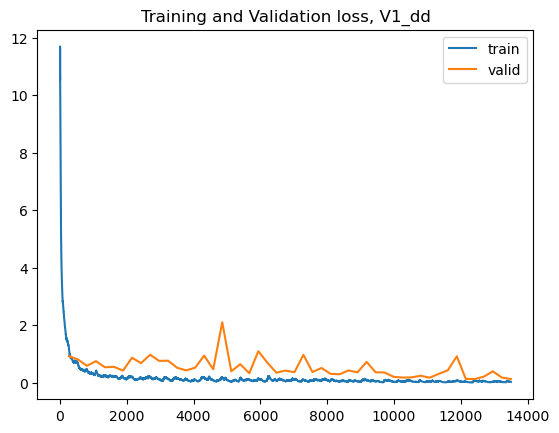

Testing model...


  0%|          | 0/85 [00:00<?, ?it/s]

                                                                              precision    recall  f1-score   support

                                                                    Acute MI     0.9951    0.9444    0.9691       216
                              Coronary artery disease, arterial hypertension     0.9769    0.9769    0.9769       216
Coronary artery disease, arterial hypertension, left ventricular hypertrophy     0.9920    0.9444    0.9677       396
                                                                  Earlier MI     0.9639    0.9877    0.9756       324
                                                                      Normal     0.9783    0.9967    0.9875      1224
                                                      Sinus node dysfunction     1.0000    0.9722    0.9859        72
                                                   Transient ischemic attack     0.9802    0.9841    0.9822       252

                                                      

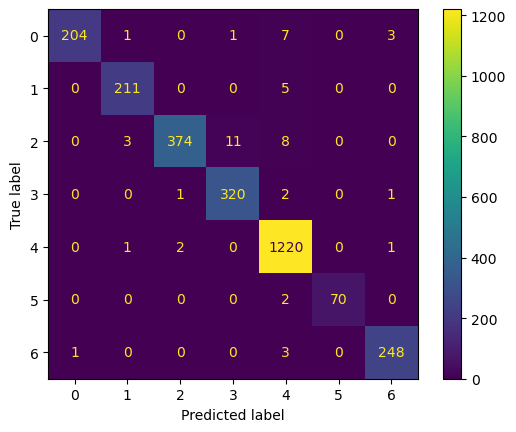

In [60]:
run_pipeline(['V1'])

epoch,train_loss,valid_loss,f1_score,time
0,1.315683,1.036064,0.549836,00:11
1,0.685078,0.727195,0.705295,00:11
2,0.519272,0.538367,0.772173,00:11
3,0.378902,0.638227,0.792049,00:11
4,0.265018,0.715772,0.828862,00:11
5,0.208911,0.523692,0.901337,00:11
6,0.193972,0.571359,0.881397,00:11
7,0.167716,0.772447,0.855763,00:11
8,0.199664,0.345671,0.913143,00:11
9,0.255072,0.644799,0.875209,00:11


Better model found at epoch 0 with f1_score value: 0.5498363708193866.
Better model found at epoch 1 with f1_score value: 0.7052948229069528.
Better model found at epoch 2 with f1_score value: 0.7721727370773263.
Better model found at epoch 3 with f1_score value: 0.7920494394057505.
Better model found at epoch 4 with f1_score value: 0.8288622896157045.
Better model found at epoch 5 with f1_score value: 0.9013370735563564.
Better model found at epoch 8 with f1_score value: 0.9131428004726462.
Better model found at epoch 10 with f1_score value: 0.9289639423452916.
Better model found at epoch 14 with f1_score value: 0.9389175582629026.
Better model found at epoch 15 with f1_score value: 0.9491173286857572.
Better model found at epoch 18 with f1_score value: 0.9511926283945688.
Better model found at epoch 21 with f1_score value: 0.9527245672279683.
Better model found at epoch 23 with f1_score value: 0.9575969947657987.
Better model found at epoch 24 with f1_score value: 0.9627959970230631.

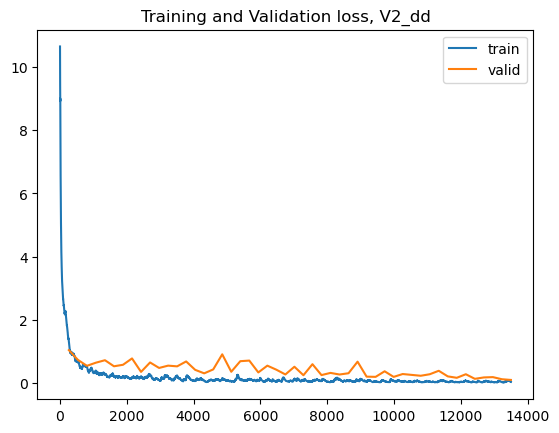

Testing model...


  0%|          | 0/85 [00:00<?, ?it/s]

                                                                              precision    recall  f1-score   support

                                                                    Acute MI     1.0000    0.9769    0.9883       216
                              Coronary artery disease, arterial hypertension     0.9764    0.9583    0.9673       216
Coronary artery disease, arterial hypertension, left ventricular hypertrophy     0.9897    0.9747    0.9822       396
                                                                  Earlier MI     0.9730    1.0000    0.9863       324
                                                                      Normal     0.9862    0.9918    0.9890      1224
                                                      Sinus node dysfunction     1.0000    0.9722    0.9859        72
                                                   Transient ischemic attack     0.9921    0.9960    0.9941       252

                                                      

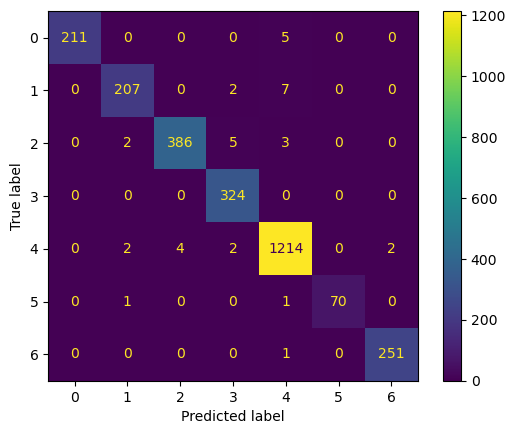

In [61]:
run_pipeline(['V2'])

epoch,train_loss,valid_loss,f1_score,time
0,1.608906,1.054405,0.695189,00:11
1,0.771576,0.823460,0.704235,00:11
2,0.827153,1.029942,0.653475,00:11
3,0.410909,0.503512,0.819747,00:11
4,0.341784,0.550636,0.836755,00:11
5,0.255095,0.482513,0.890808,00:11
6,0.244062,0.412063,0.894314,00:11
7,0.180922,0.837808,0.819916,00:11
8,0.238953,0.572034,0.886416,00:11
9,0.131607,0.341221,0.906497,00:11


Better model found at epoch 0 with f1_score value: 0.6951887077303509.
Better model found at epoch 1 with f1_score value: 0.704235398258537.
Better model found at epoch 3 with f1_score value: 0.8197472567606081.
Better model found at epoch 4 with f1_score value: 0.8367552828986955.
Better model found at epoch 5 with f1_score value: 0.8908078930400393.
Better model found at epoch 6 with f1_score value: 0.8943135265376889.
Better model found at epoch 9 with f1_score value: 0.9064967743132766.
Better model found at epoch 10 with f1_score value: 0.9158811090757856.
Better model found at epoch 11 with f1_score value: 0.9183703767669016.
Better model found at epoch 12 with f1_score value: 0.9326902773659693.
Better model found at epoch 17 with f1_score value: 0.9355687439982546.
Better model found at epoch 20 with f1_score value: 0.9390059239569164.
Better model found at epoch 21 with f1_score value: 0.9420138927360511.
Better model found at epoch 27 with f1_score value: 0.9459323491010153.


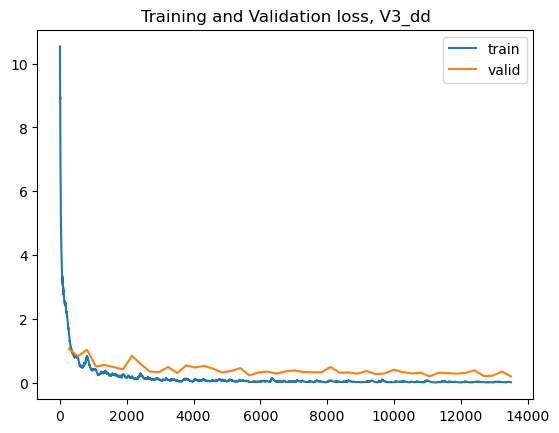

Testing model...


  0%|          | 0/85 [00:00<?, ?it/s]

                                                                              precision    recall  f1-score   support

                                                                    Acute MI     0.9548    0.9769    0.9657       216
                              Coronary artery disease, arterial hypertension     0.9442    0.8611    0.9007       216
Coronary artery disease, arterial hypertension, left ventricular hypertrophy     0.9169    0.9470    0.9317       396
                                                                  Earlier MI     0.9904    0.9568    0.9733       324
                                                                      Normal     0.9694    0.9575    0.9634      1224
                                                      Sinus node dysfunction     0.8659    0.9861    0.9221        72
                                                   Transient ischemic attack     0.9108    0.9722    0.9405       252

                                                      

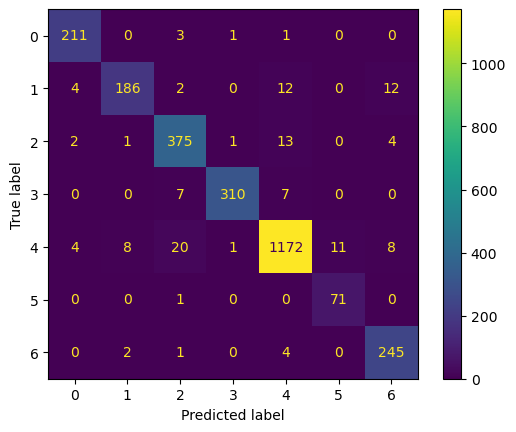

In [62]:
run_pipeline(['V3'])

epoch,train_loss,valid_loss,f1_score,time
0,2.438121,2.336353,0.522445,00:11
1,0.908256,0.818640,0.679417,00:11
2,0.570629,0.739712,0.783018,00:10
3,0.374779,0.605147,0.797046,00:11
4,0.326388,0.361380,0.838022,00:11
5,0.241583,0.380135,0.893901,00:11
6,0.328820,0.318128,0.884739,00:11
7,0.205151,0.858248,0.810644,00:11
8,0.107540,0.341969,0.914445,00:11
9,0.165396,0.626868,0.866488,00:11


Better model found at epoch 0 with f1_score value: 0.5224449226416873.
Better model found at epoch 1 with f1_score value: 0.67941744809955.
Better model found at epoch 2 with f1_score value: 0.783017970375066.
Better model found at epoch 3 with f1_score value: 0.7970456676426404.
Better model found at epoch 4 with f1_score value: 0.8380223003649113.
Better model found at epoch 5 with f1_score value: 0.8939006925013943.
Better model found at epoch 8 with f1_score value: 0.9144447368470104.
Better model found at epoch 12 with f1_score value: 0.9199743233943732.
Better model found at epoch 17 with f1_score value: 0.9397269518345984.
Better model found at epoch 26 with f1_score value: 0.9528367501464597.


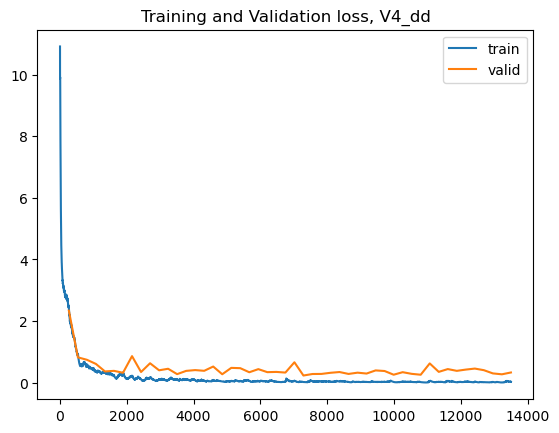

Testing model...


  0%|          | 0/85 [00:00<?, ?it/s]

                                                                              precision    recall  f1-score   support

                                                                    Acute MI     0.9949    0.9074    0.9492       216
                              Coronary artery disease, arterial hypertension     0.9592    0.8704    0.9126       216
Coronary artery disease, arterial hypertension, left ventricular hypertrophy     0.9562    0.9369    0.9464       396
                                                                  Earlier MI     0.9727    0.9907    0.9817       324
                                                                      Normal     0.9470    0.9779    0.9622      1224
                                                      Sinus node dysfunction     1.0000    0.9306    0.9640        72
                                                   Transient ischemic attack     0.9419    0.9643    0.9529       252

                                                      

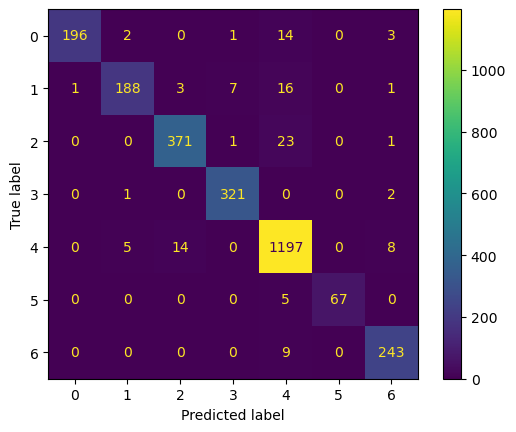

In [63]:
run_pipeline(['V4'])

epoch,train_loss,valid_loss,f1_score,time
0,2.052383,1.512835,0.545238,00:11
1,0.736057,0.850229,0.657180,00:11
2,0.527017,0.702916,0.719544,00:11
3,0.466408,0.337976,0.847314,00:11
4,0.357361,0.392884,0.856373,00:11
5,0.257830,0.545746,0.863112,00:11
6,0.261045,0.504898,0.872786,00:11
7,0.185770,0.333066,0.895435,00:11
8,0.145206,0.434443,0.879513,00:11
9,0.125411,0.586345,0.881218,00:11


Better model found at epoch 0 with f1_score value: 0.5452376412432439.
Better model found at epoch 1 with f1_score value: 0.6571801190878419.
Better model found at epoch 2 with f1_score value: 0.7195436851172511.
Better model found at epoch 3 with f1_score value: 0.8473140930841749.
Better model found at epoch 4 with f1_score value: 0.8563729769037564.
Better model found at epoch 5 with f1_score value: 0.8631119262141418.
Better model found at epoch 6 with f1_score value: 0.872786424995379.
Better model found at epoch 7 with f1_score value: 0.895435283002374.
Better model found at epoch 11 with f1_score value: 0.9124849826196005.
Better model found at epoch 12 with f1_score value: 0.9150265037867052.
Better model found at epoch 15 with f1_score value: 0.9187531583759786.
Better model found at epoch 16 with f1_score value: 0.9215135144356064.
Better model found at epoch 28 with f1_score value: 0.9269643782479587.
Better model found at epoch 33 with f1_score value: 0.9312830621206695.
Be

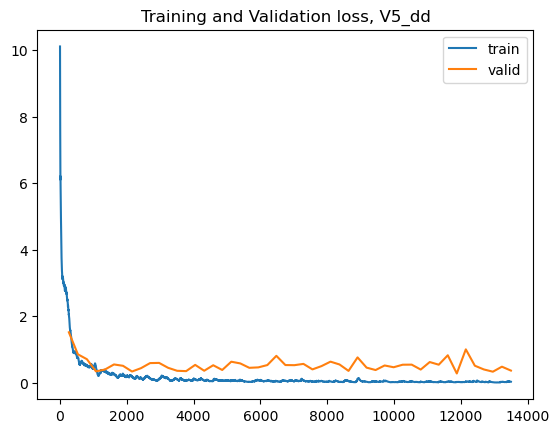

Testing model...


  0%|          | 0/85 [00:00<?, ?it/s]

                                                                              precision    recall  f1-score   support

                                                                    Acute MI     0.9651    0.7685    0.8557       216
                              Coronary artery disease, arterial hypertension     0.9502    0.9722    0.9611       216
Coronary artery disease, arterial hypertension, left ventricular hypertrophy     0.9845    0.9646    0.9745       396
                                                                  Earlier MI     0.9555    0.9938    0.9743       324
                                                                      Normal     0.9556    0.9502    0.9529      1224
                                                      Sinus node dysfunction     0.9342    0.9861    0.9595        72
                                                   Transient ischemic attack     0.8408    0.9643    0.8983       252

                                                      

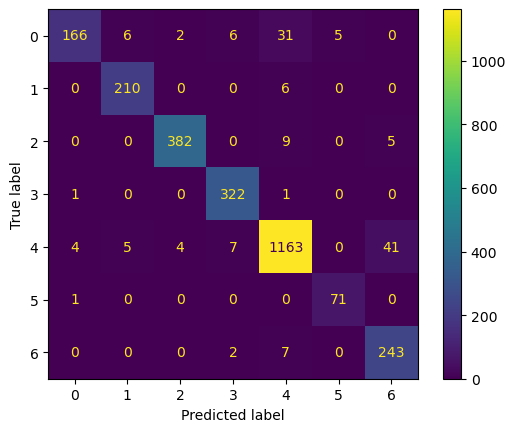

In [64]:
run_pipeline(['V5'])

epoch,train_loss,valid_loss,f1_score,time
0,2.063071,1.878584,0.470338,00:11
1,0.738439,0.633137,0.739427,00:11
2,0.550265,0.532654,0.769987,00:11
3,0.381786,0.666313,0.792639,00:11
4,0.327893,0.611187,0.813915,00:11
5,0.245767,0.564727,0.859274,00:11
6,0.193722,0.515142,0.878628,00:11
7,0.171462,0.531613,0.869064,00:11
8,0.152946,0.569994,0.880785,00:11
9,0.136558,0.542594,0.875356,00:11


Better model found at epoch 0 with f1_score value: 0.4703384984802228.
Better model found at epoch 1 with f1_score value: 0.7394272061395746.
Better model found at epoch 2 with f1_score value: 0.7699865893294735.
Better model found at epoch 3 with f1_score value: 0.7926389923189875.
Better model found at epoch 4 with f1_score value: 0.8139145510012655.
Better model found at epoch 5 with f1_score value: 0.8592737303678395.
Better model found at epoch 6 with f1_score value: 0.87862829728308.
Better model found at epoch 8 with f1_score value: 0.8807851911326046.
Better model found at epoch 11 with f1_score value: 0.9117257354818257.
Better model found at epoch 20 with f1_score value: 0.9313499600368969.
Better model found at epoch 31 with f1_score value: 0.9371043109032584.


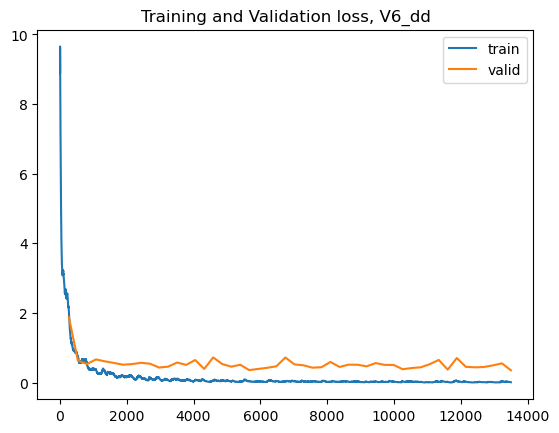

Testing model...


  0%|          | 0/85 [00:00<?, ?it/s]

                                                                              precision    recall  f1-score   support

                                                                    Acute MI     0.9780    0.8241    0.8945       216
                              Coronary artery disease, arterial hypertension     0.9268    0.8796    0.9026       216
Coronary artery disease, arterial hypertension, left ventricular hypertrophy     0.9657    0.9242    0.9445       396
                                                                  Earlier MI     0.9642    0.9136    0.9382       324
                                                                      Normal     0.8974    0.9722    0.9333      1224
                                                      Sinus node dysfunction     0.9559    0.9028    0.9286        72
                                                   Transient ischemic attack     0.9356    0.8651    0.8990       252

                                                      

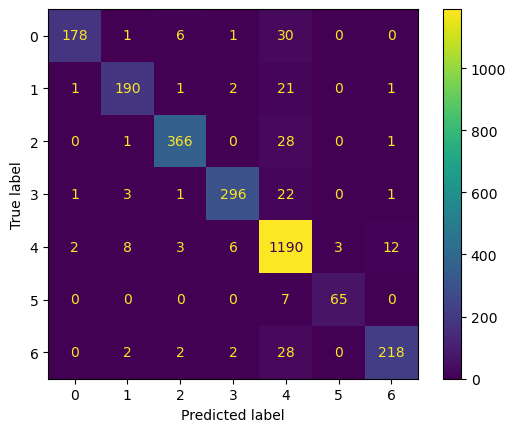

In [65]:
run_pipeline(['V6'])

epoch,train_loss,valid_loss,f1_score,time
0,0.585482,1.312516,0.748747,00:12
1,0.449564,1.431457,0.840327,00:11
2,0.355732,0.771734,0.878915,00:12
3,0.157322,0.420520,0.965693,00:12
4,0.368508,1.385935,0.907499,00:11
5,0.341014,0.760618,0.931920,00:12
6,0.270487,1.428095,0.911629,00:12
7,0.191367,0.295607,0.974061,00:11
8,0.259052,0.738692,0.948026,00:12
9,0.115832,0.233005,0.981631,00:11


Better model found at epoch 0 with f1_score value: 0.7487472440779699.
Better model found at epoch 1 with f1_score value: 0.8403269616784207.
Better model found at epoch 2 with f1_score value: 0.8789154795758837.
Better model found at epoch 3 with f1_score value: 0.9656933890808449.
Better model found at epoch 7 with f1_score value: 0.9740612349938688.
Better model found at epoch 9 with f1_score value: 0.9816314973330794.
Better model found at epoch 13 with f1_score value: 0.989803917100696.
Better model found at epoch 15 with f1_score value: 0.9911811016190033.
Better model found at epoch 20 with f1_score value: 0.9939753029555808.
Better model found at epoch 32 with f1_score value: 0.9976870287857144.


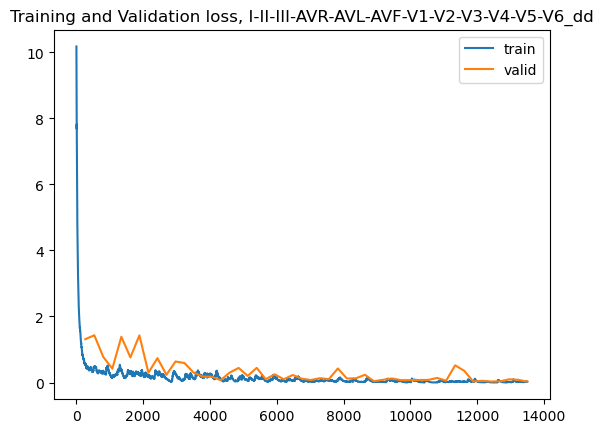

Testing model...


  0%|          | 0/85 [00:00<?, ?it/s]

                                                                              precision    recall  f1-score   support

                                                                    Acute MI     0.9954    0.9954    0.9954       216
                              Coronary artery disease, arterial hypertension     1.0000    0.9907    0.9953       216
Coronary artery disease, arterial hypertension, left ventricular hypertrophy     0.9975    1.0000    0.9987       396
                                                                  Earlier MI     1.0000    0.9907    0.9953       324
                                                                      Normal     0.9959    0.9975    0.9967      1224
                                                      Sinus node dysfunction     0.9863    1.0000    0.9931        72
                                                   Transient ischemic attack     0.9960    1.0000    0.9980       252

                                                      

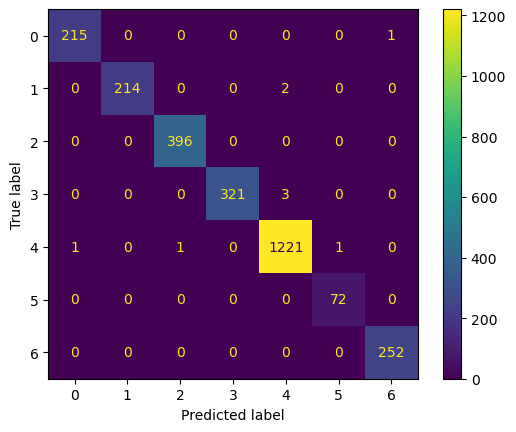

In [66]:
run_pipeline(['I','II','III','AVR','AVL','AVF','V1','V2','V3','V4','V5','V6'])